#  RESEARCH PROJECT B
Student: Mr Eloy Ruiz Donayre  
Supervisor: Prof Dr Achim Kehrein  

Reference Paper:  
> To sleep or not to sleep: the ecology of sleep in artificial organisms  
> Alberto Acerbi, Patrick McNamara and Charles L Nunn  
> https://doi.org/10.1186/1472-6785-8-10 

## Data Analysis (50 generations)
The reference paper does statistical analysis on the aggregate date of many runs of 100 generations with varying parameter between runs. Some of the analysis are:

- Interdistance vs number of sleep bouts
- Interdistance vs number of monophasic sleepers
- Food patch depletion rate vs average sleep time
- Number of food patches vs average sleep time
- Number of sleep patches vs average sleep time
- Number of food and sleep patches vs average sleep time
- Preference for the flexible gene triples.

At the moment, I'm unsuccesful in running one full run of a 100 generations. So, an aggregate analysis is outside of my reach.

Instead I'm showing for a run of 50 generations a data analysis of the evolution during the run of the following parameters:

- Average fitness of the population in each generation
- Maximum fitness of an individual in each generation
- Average number of sleep minutes of the population in each generation
- Number of gene triples of interest in the population in each generation

#### Setting up modules

In [1]:
%matplotlib inline
import seaborn as sns
sns.set()

# from jupyterthemes import jtplot
# jtplot.style()

In [2]:
import math
import random
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from simulation_modules.rpb_agents import Animal, FoodPatch, SleepPatch
from simulation_modules.rpb_simmodel import SleepAnimals_sinDataColl
from simulation_modules.rpb_experiment import *

Importing C:\Users\EloyR\source\repos\research-project-b\simulation_modules\__init__.py
Importing C:\Users\EloyR\source\repos\research-project-b\simulation_modules\rpb_agents.py
Importing C:\Users\EloyR\source\repos\research-project-b\simulation_modules\rpb_simmodel.py
Importing C:\Users\EloyR\source\repos\research-project-b\simulation_modules\rpb_experiment.py


In [3]:
current_exp_id = 0
generation_number = 0
abm_models = []
generations = []
results = pd.DataFrame()
p = 0.05

#### Creating genomes of initial population
The array `genomes` represent the genomes of the first 100 individuals. Each gene in the genome has three possible values:  
`'flex' , 'eat' , 'sleep'`

In [4]:
genomes = genome_alternatives(100)
np.shape(genomes)
selected_genomes = genomes

### Executing 40 generations
Parameters of execution:

- Width: 40 cells, Height: 40 cells
- Interdistance factor: 0.7 => Interdistance: 56 grids (Manhattan distance between center of clusters)
- Intradistance factor: 0.2 => Intradistance: 16 (Manhattan size of cluster)
- Energy lost (food and sleep) while moving: 1
- Energy won from a sleep patch: 3
- Ticks for depletion of a food patch: 60 ticks
- Food patches: 40 ; Sleep patches: 40
- For each agent, the simulation runs for 7 days, with each tick representing one minute
- Each generation has 100 individuals.
- The 20 most fit individuals are selected as parents of the new generation. Each one produces 5 offspring, for each gene of the new individuals there is a 5% chance of mutation.

In [5]:
%%time
for run_generations in range (50):
    # Creating the Agent-Based models for the current generation and running it for 7 days.
    for current_exp_id in range(100*generation_number + 0, 100*generation_number + 100):
        i = current_exp_id
        abm_models.append( SleepAnimals_sinDataColl(i, genome=selected_genomes[i-100*generation_number], 
                                        width=40, height=40, sleep_and_food_gainfactor=1) )
        for j in range(60*24*7):
            abm_models[i].step()
    
    # Capturing the data from the end of the simulation
    current_generation = []
    for k in range(100*generation_number + 0, 100*generation_number + 100):
        (x,y,z) = phases_in_genome( abm_models[k].schedule.agents[0].circadian_rythm )
        
        a = [ abm_models[k].model_id , abm_models[k].schedule.agents[0].fitness , 
             abm_models[k].schedule.agents[0].circadian_rythm, abm_models[k].schedule.agents[0].minutes_asleep,
             x, y, z ]
        current_generation.append( a )
    
#    generation_results = dataframe_generation(generation_number , current_generation)
#    results = results.append(generation_results)
    current_generation.sort(key = lambda x : x[1], reverse=True)
    generation_number += 1
    generations.append( current_generation )
    
    # Generating the new population from the fittest individuals
    selected_genomes = np.full( (100 , 24) , 'sleep')
    for l in range(20):
        for m in range(5):
            for n in range(24):
                a = current_generation[l][2][n]
                a = mutation_gene( a , p )
                selected_genomes[int(100/20)*l + m] [n] = a

Wall time: 33min 3s


## Data analysis

### Evolution of average fitness and maximum fitness per generation

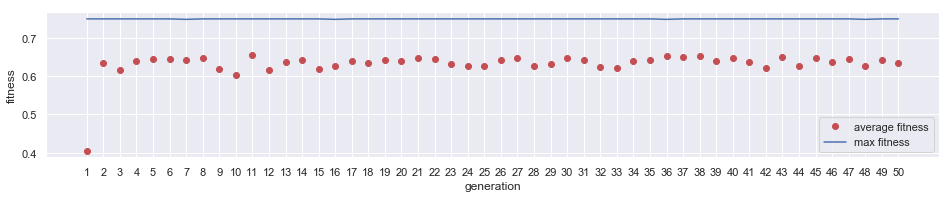

In [6]:
x = []
average_fitness = []
top_fitness = []
for j in range( len(generations) ):
    data = [ generations[j][i][1] for i in range(100) ]
    top_fitness.append( generations[j][0][1] )
    average_fitness.append( np.average(data) )
    x.append( j+1 )

w,h = matplotlib.figure.figaspect(1/6)
_= plt.figure(figsize=(w,h))
_= plt.plot(x, average_fitness, "ro", label='average fitness')
_= plt.plot(x, top_fitness, label='max fitness')
_= plt.xticks( np.arange(1,len(generations)+1,1) )
_= plt.xlabel('generation')
_= plt.ylabel('fitness')
_= plt.legend()

### Evolution of minutes asleep per generation

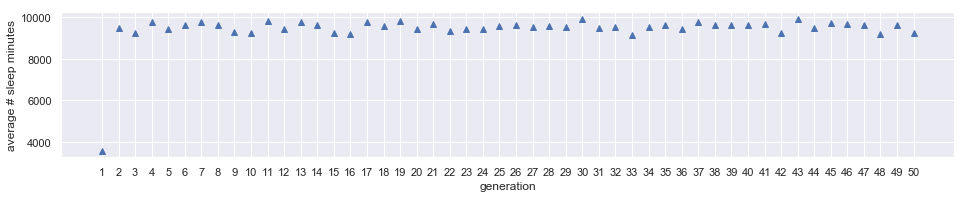

In [7]:
x = []
average_minutes_asleep = []
for j in range( len(generations) ):
    data = [ generations[j][i][3] for i in range(100) ]
    average_minutes_asleep.append( np.average(data) )
    x.append( j+1 )

w,h = matplotlib.figure.figaspect(1/6)
_= plt.figure(figsize=(w,h))
_= plt.plot(x, average_minutes_asleep, "b^")
_= plt.xticks( np.arange(1,len(generations)+1,1) )
_= plt.xlabel('generation')
_= plt.ylabel('average # sleep minutes')

### Evolution of the fitness of the genome sequences E-F-E, S-F-S, and S-F-E with E-F-S combined.
The reference paper analizes the genome structure in relation to fitness by analizing the appearance of the following sequences:

E-F-E = Eat-Flex-Eat  
S-F-S = Sleep-Flex-Sleep  
E-F-S or S-F-E = Eat-Flex-Sleep or Sleep-Flex-Eat  

In each sequence, an element represents one gene or a group of genes with the same value.

Here, in each generation and for each sequence an average fitness value is presented that is the fitness value of each individual that posseses the sequence, weighted with the number of times the sequence appears in the genome.

In [8]:
x = []
average_fitness_efe = []
average_fitness_sfs = []
average_fitness_sfe_inv = []

for j in range( len(generations) ):
    data_fitness   = [ generations[j][i][1] for i in range(100) ]
    data_efe       = [ generations[j][i][4] for i in range(100) ]
    data_sfs       = [ generations[j][i][5] for i in range(100) ]
    data_sfe_inv   = [ generations[j][i][6] for i in range(100) ]
    
    average_fitness_efe.append(     np.average(data_fitness, weights= data_efe) )
    average_fitness_sfs.append(     np.average(data_fitness, weights= data_sfs) )
    average_fitness_sfe_inv.append( np.average(data_fitness, weights= data_sfe_inv) )
    x.append( j+1 )

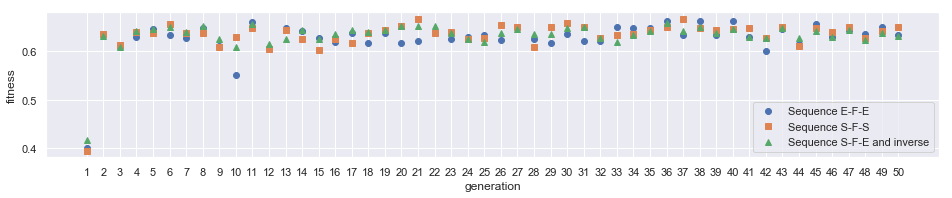

In [9]:
w,h = matplotlib.figure.figaspect(1/6)
_= plt.figure(figsize=(w,h))
_= plt.plot(x, average_fitness_efe, "o", label='Sequence E-F-E')
_= plt.plot(x, average_fitness_sfs, "s", label='Sequence S-F-S')
_= plt.plot(x, average_fitness_sfe_inv, "^", label='Sequence S-F-E and inverse')
_= plt.xticks( np.arange(1,len(generations)+1,1) )
_= plt.xlabel('generation')
_= plt.ylabel('fitness')
_= plt.legend()

### Evolution of the relative proportion of the genome sequences E-F-E, S-F-S, and S-F-E with E-F-S combined.
Here, in each generation and for each sequence the number of times that the sequence appears in the population is shown.

In [10]:
x = []
appearance_efe = []
appearance_sfs = []
appearance_sfe_inv = []

for j in range( len(generations) ):
    appearance_efe_d       = np.sum([ generations[j][i][4] for i in range(100) ])
    appearance_sfs_d       = np.sum([ generations[j][i][5] for i in range(100) ])
    appearance_sfe_inv_d   = np.sum([ generations[j][i][6] for i in range(100) ])
    appearance_total_d     = appearance_efe_d + appearance_sfs_d + appearance_sfe_inv_d
    
    appearance_efe.append(     appearance_efe_d )
    appearance_sfs.append(     appearance_sfs_d ) 
    appearance_sfe_inv.append( appearance_sfe_inv_d )
    x.append( j+1 )

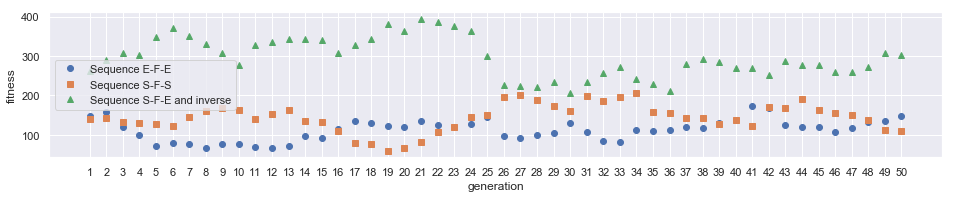

In [11]:
w,h = matplotlib.figure.figaspect(1/6)
_= plt.figure(figsize=(w,h))
_= plt.plot(x, appearance_efe, "o", label='Sequence E-F-E')
_= plt.plot(x, appearance_sfs, "s", label='Sequence S-F-S')
_= plt.plot(x, appearance_sfe_inv, "^", label='Sequence S-F-E and inverse')
_= plt.xticks( np.arange(1,len(generations)+1,1) )
_= plt.xlabel('generation')
_= plt.ylabel('fitness')
_= plt.legend()